In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os

In [2]:
import ee
import geemap
service_account = ' boba-account@boba-430314.iam.gserviceaccount.com '
credentials = ee.ServiceAccountCredentials(service_account,'C:/Users/arj26323/OneDrive - University of Georgia/Documents/GEE AUTH/boba-430314-a19be859bfca.json')

ee.Initialize(credentials)

print(geemap.__version__)

0.34.1


In [19]:
Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

##Adding every plot coordinate
allplots_fc = 'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/GA_allplots_NEW.csv'

x = pd.read_csv(allplots_fc).groupby(['Latitude', 'Longitude']).first().reset_index()

fc_all = geemap.pandas_to_ee(x, latitude = "Latitude", longitude = "Longitude") ##FOR DAYMET AND GRIDMET

# fc_all = geemap.csv_to_ee(allplots, latitude = "Latitude", longitude = "Longitude") ##FOR LS DATA

In [4]:
def maskL8sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [5]:
#12/08/22 - adding CALIBRATED FLATS
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

##MASKING FLATS
def maskFLATS(image):
    mask1 = image.select('flats').lte(0.2) #less than or equal to 0.1 - change?
    return image.updateMask(mask1)

##ADDING NDVI (for min/max variables)
def addL5ndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

def addL8ndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

In [6]:
##Pixel extraction functions - addDate for dateless images/collections
def addDate(image):
    img_date = ee.Date(image.date())
    img_date = ee.Number.parse(img_date.format('YYYYMMdd'))
    return image.addBands(ee.Image(img_date).rename('imagedate').toInt())

##For Landsat images:
# def rasterExtraction(image):
#     feature = image.sampleRegions(
#         collection = fc_all,
#         scale = 30,
#         tileScale = 16 #ADDED 10/6/2022 - make sure it doesn't affect results (see thread below)
#     )
#     return feature


def rasterExtraction(image, fc_subset):
    return image.sampleRegions(
        collection=fc_subset,  # Use the subset of locations
        scale=30,
        tileScale=8  # Adjust tile scale for performance
    ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))


##FOR 10m DEM:
def demExtraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 10 
    )
    return feature

##FOR 1m DEM:
def dem1Extraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 1, 
        tileScale = 16 #ADDED 11/7/2022

    )
    return feature

In [30]:
#Datasets - NOT MASKING FLATS (try again masking later)
ls5_collect = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterBounds(fc_all).map(maskL8sr).map(addFLATSL5)
ls7_collect = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(fc_all).map(maskL8sr).map(addFLATSL7)
ls8_collect = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(fc_all).map(maskL8sr).map(addFLATSL8)
ls9_collect = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2').filterBounds(fc_all).map(maskL8sr).map(addFLATSL8)

#Merge
ultra_col = ls8_collect.merge(ls5_collect).merge(ls7_collect).merge(ls9_collect)

In [31]:
Map.addLayer(fc_all)
# Map

hi


In [14]:
#LANDSAT extraction

def rasterExtraction(image, fc_subset):
    return image.sampleRegions(
        collection=fc_subset,  # Use the subset of locations
        scale=30,
        tileScale=8  # Adjust tile scale for performance
    ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))

out_dir = os.path.expanduser('~/Documents/All extract/GA')

# Split locations into batches of 100
batch_size = 100
fc_list = fc_all.toList(fc_all.size())  # Convert to list
num_features = fc_all.size().getInfo()

# # Calculate the number of batches without math.ceil()
# num_batches = (num_features + batch_size - 1) // batch_size  # Equivalent to math.ceil(num_features / batch_size)

# years = range(1984, 2025)

# for year in years:
#     for batch in range(num_batches):
#         # Subset locations for this batch
#         fc_subset = ee.FeatureCollection(fc_list.slice(batch * batch_size, (batch + 1) * batch_size))

#         print(f"Processing {year}, Batch {batch + 1}/{num_batches}...")

#         # Filter Landsat images for the year
#         subset = ultra_col.filterDate(f"{year}-01-01", f"{year}-12-31")

#         # Fix: Use a lambda function to pass `fc_subset` properly
#         extracted_features = subset.map(lambda img: rasterExtraction(img, fc_subset)).flatten()

#         fc_dict = extracted_features.getInfo()
#         features = [feature['properties'] for feature in fc_dict['features']]
#         df = pd.DataFrame(features)
#         df['date'] = pd.to_datetime(df['date'])

#         # Save file in the specified directory
#         filename = os.path.join(out_dir, f"GALandsat_{year}_batch{batch + 1}.csv")
#         df.to_csv(filename, index=False)
#         print(f"Saved {filename}")

# print("All batches processed!")


Processing 2022, Batch 1/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2022_batch1.csv
Processing 2022, Batch 2/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2022_batch2.csv
Processing 2022, Batch 3/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2022_batch3.csv
Processing 2022, Batch 4/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2022_batch4.csv
Processing 2022, Batch 5/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2022_batch5.csv
Processing 2022, Batch 6/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2022_batch6.csv
Processing 2022, Batch 7/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2022_batch7.csv
Processing 2022, Batch 8/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2022_batch8.csv
Processing 2022, Batch 9/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2022_batch9.csv
Processing 2022, Batch 10/46...
Saved C:\Users

Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2023_batch31.csv
Processing 2023, Batch 32/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2023_batch32.csv
Processing 2023, Batch 33/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2023_batch33.csv
Processing 2023, Batch 34/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2023_batch34.csv
Processing 2023, Batch 35/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2023_batch35.csv
Processing 2023, Batch 36/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2023_batch36.csv
Processing 2023, Batch 37/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2023_batch37.csv
Processing 2023, Batch 38/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2023_batch38.csv
Processing 2023, Batch 39/46...
Saved C:\Users\arj26323/Documents/All extract/GA\GALandsat_2023_batch39.csv
Processing 2023, Batch 40/46...
Saved C:\Users\arj26323/Docu

In [28]:
##DAYMET
daymet = ee.ImageCollection('NASA/ORNL/DAYMET_V4').filterBounds(fc_all).filterDate('2023', '2025')

# def dmExtraction(image, fc_subset):
#     return image.sampleRegions(
#         collection=fc_subset,
#         scale=1000,
#         tileScale=8  # Reducing from 16 to 8 to improve efficiency
#     ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))

#Resampling daymet collection to 30m
def resamp_dm(img):
    resampled_dm = img.reproject(
        crs = 'EPSG:4326',
        scale = 30
    ).resample('bilinear')
    return resampled_dm
resamp_daymet = daymet.map(resamp_dm).map(addDate) #not sure if anything is actually changed

out_dir = os.path.expanduser('~/Documents/All extract/GA_daymet')



def xxx(image):
    return image.sampleRegions(
        collection=fc_all,
        scale=1000,
        tileScale=8  # Reducing from 16 to 8 to improve efficiency
    ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))


extracted_features = resamp_daymet.map(xxx)
fc_dict = extracted_features.getInfo()   
features = [feature['properties'] for feature in fc_dict['features']]
df = pd.DataFrame(features)
df


# # Split locations into batches of 100
# batch_size = 100
# fc_list = fc_all.toList(fc_all.size())  # Convert to list
# num_features = fc_all.size().getInfo()

# # Calculate the number of batches without math.ceil()
# num_batches = (num_features + batch_size - 1) // batch_size  # Equivalent to math.ceil(num_features / batch_size)

# years = range(2000, 2025)

# for year in years:
#     for batch in range(num_batches):
#         # Subset locations for this batch
#         fc_subset = ee.FeatureCollection(fc_list.slice(batch * batch_size, (batch + 1) * batch_size))

#         print(f"Processing {year}, Batch {batch + 1}/{num_batches}...")

#         # Filter Landsat images for the year
#         subset = resamp_daymet.filterDate(f"{year}-01-01", f"{year}-12-31")

#         # Fix: Use a lambda function to pass `fc_subset` properly
#         extracted_features = subset.map(lambda img: rasterExtraction(img, fc_subset)).flatten()

#         fc_dict = extracted_features.getInfo()
#         features = [feature['properties'] for feature in fc_dict['features']]
#         df = pd.DataFrame(features)
#         df['date'] = pd.to_datetime(df['date'])

#         # Save file in the specified directory
#         filename = os.path.join(out_dir, f"GADaymet_{year}_batch{batch + 1}.csv")
#         df.to_csv(filename, index=False)
#         print(f"Saved {filename}")

# print("All batches processed!")

,system:index,band_order
0,20230101,"[dayl, prcp, srad, swe, tmax, tmin, vp, imaged..."
1,20230102,"[dayl, prcp, srad, swe, tmax, tmin, vp, imaged..."
2,20230103,"[dayl, prcp, srad, swe, tmax, tmin, vp, imaged..."
3,20230104,"[dayl, prcp, srad, swe, tmax, tmin, vp, imaged..."
4,20230105,"[dayl, prcp, srad, swe, tmax, tmin, vp, imaged..."
...,...,...
360,20231227,"[dayl, prcp, srad, swe, tmax, tmin, vp, imaged..."
361,20231228,"[dayl, prcp, srad, swe, tmax, tmin, vp, imaged..."
362,20231229,"[dayl, prcp, srad, swe, tmax, tmin, vp, imaged..."
363,20231230,"[dayl, prcp, srad, swe, tmax, tmin, vp, imaged..."


In [29]:
def sample_daymet_for_year(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')
    
    daymet = ee.ImageCollection('NASA/ORNL/DAYMET_V4') \
        .filterDate(start, end) \
        .filterBounds(fc_all)

    def sample_image(image):
        sampled = image.sampleRegions(
            collection=fc_all,
            scale=1000,
            tileScale=8
        ).map(lambda f: f.set('date', image.date().format('YYYY-MM-dd')))
        return sampled

    sampled = daymet.map(sample_image).flatten()
    
    task = ee.batch.Export.table.toDrive(
        collection=sampled,
        description=f'DAYMET_sample_{year}',
        folder='daymet_samples',
        fileFormat='CSV'
    )
    task.start()

# Loop over years and start a separate export task for each
for year in range(2000, 2025):
    sample_daymet_for_year(year)

AttributeError: module 'geemap' has no attribute 'ee_task_manager'

In [ ]:
##GRIDMET
gridmet = ee.ImageCollection('GRIDMET/DROUGHT').filterBounds(fc_all)

resamp_gridmet = gridmet.map(resamp_dm).map(addDate)

out_dir = os.path.expanduser('~/Documents/All extract/GA_gridmet')

# Split locations into batches of 100
batch_size = 100
fc_list = fc_all.toList(fc_all.size())  # Convert to list
num_features = fc_all.size().getInfo()

# Calculate the number of batches without math.ceil()
num_batches = (num_features + batch_size - 1) // batch_size  # Equivalent to math.ceil(num_features / batch_size)

years = range(2000, 2025)

for year in years:
    for batch in range(num_batches):
        # Subset locations for this batch
        fc_subset = ee.FeatureCollection(fc_list.slice(batch * batch_size, (batch + 1) * batch_size))

        print(f"Processing {year}, Batch {batch + 1}/{num_batches}...")

        # Filter Landsat images for the year
        subset = resamp_gridmet.filterDate(f"{year}-01-01", f"{year}-12-31")

        # Fix: Use a lambda function to pass `fc_subset` properly
        extracted_features = subset.map(lambda img: rasterExtraction(img, fc_subset)).flatten()

        fc_dict = extracted_features.getInfo()
        features = [feature['properties'] for feature in fc_dict['features']]
        df = pd.DataFrame(features)
        df['date'] = pd.to_datetime(df['date'])

        # Save file in the specified directory
        filename = os.path.join(out_dir, f"GAGridmet_{year}_batch{batch + 1}.csv")
        df.to_csv(filename, index=False)
        print(f"Saved {filename}")

print("All batches processed!")

In [41]:
#Elevation

##FOR 10m DEM:
def demExtraction(image):
    feature = image.sampleRegions(
        collection = fc_all,
        scale = 10 
    )
    return feature

dem = ee.Image('USGS/3DEP/10m') ##This is 1/3 arc second, or 10 m.

#Elevation
dem_extract = demExtraction(dem)
# dem_vals = geemap.ee_to_csv(dem_extract, 'dem.csv') ##10m dataset

dem_dict = dem_extract.getInfo()

# Extract the properties of the features into a list of dictionaries
features = [feature['properties'] for feature in dem_dict['features']]

# Convert the list of dictionaries into a pandas DataFrame
dem_vals = pd.DataFrame(features)
dem_vals

# out_dir = os.path.expanduser('~/Documents/All extract/Elevation')

# filename = os.path.join(out_dir, "elev.csv")

# dem_vals.to_csv(filename, index=False)

In [ ]:
import glob

# path = r'C:/Users/arj26323/Documents/Xin data/Landsat' 
# all_files = glob.glob(path + "/*.csv")

# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     li.append(df)

# df = pd.concat(li, axis=0, ignore_index=True)

# df

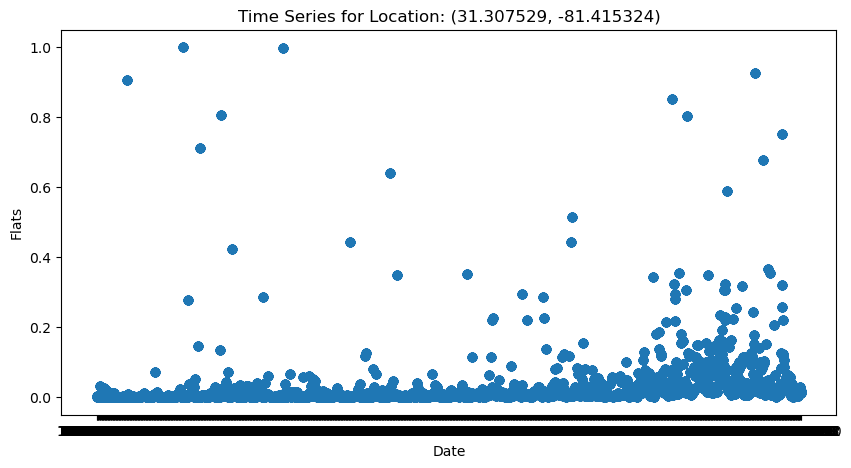

In [4]:
# # Group by unique latitude/longitude pairs
# grouped = df.groupby(['Latitude', 'Longitude'])

# # Select one unique location (e.g., first location in the grouped data)
# (lat, lon), location_df = next(iter(grouped))

# # Sort by date to ensure proper time series order
# location_df = location_df.sort_values('date')

# # Plot the time series of 'flats' for this location
# plt.figure(figsize=(10, 5))
# plt.plot(location_df['date'], location_df['flats'], marker='o', linestyle='')

# plt.xlabel("Date")
# plt.ylabel("Flats")
# plt.title(f"Time Series for Location: ({lat}, {lon})")
# plt.show()

Enter the index of the location you want to plot: 6


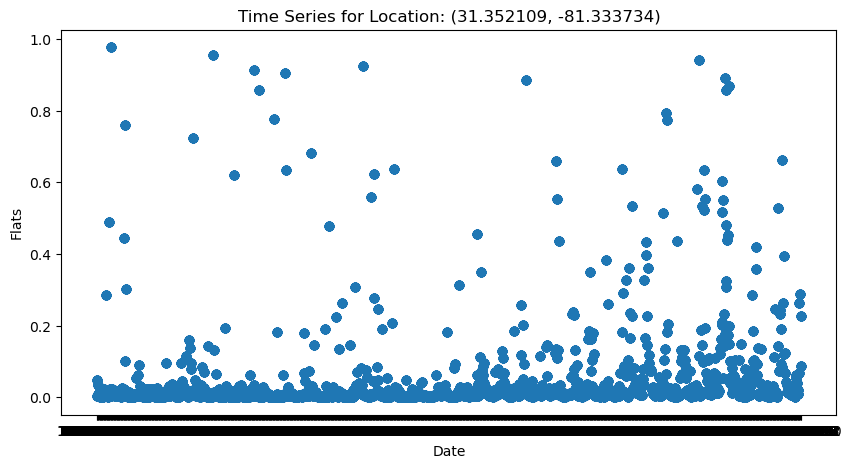

In [18]:
# # Get unique latitude/longitude pairs
# unique_locations = df[['Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True)

# # Display indexed locations
# # print("Available Locations:")
# # for i, (lat, lon) in unique_locations.iterrows():
# #     print(f"{i}: ({lat}, {lon})")

# # Ask user to select a location by index
# selection = int(input("Enter the index of the location you want to plot: "))

# # Extract selected location
# lat, lon = unique_locations.iloc[selection]

# # Filter dataframe for the selected location
# location_df = df[(df['Latitude'] == lat) & (df['Longitude'] == lon)].sort_values('date')

# # Plot time series for selected location
# plt.figure(figsize=(10, 5))
# plt.plot(location_df['date'], location_df['flats'], marker='o', linestyle='')

# plt.xlabel("Date")
# plt.ylabel("Flats")
# plt.title(f"Time Series for Location: ({lat}, {lon})")
# plt.show()

In [12]:
#df.groupby(['Latitude','Longitude']).size()

df_flooding = df.groupby(['Latitude', 'Longitude']).apply(
    lambda g: (g['flats'] >= 0.2).mean()).reset_index(name='Percent_flooding'
                                                     )
df_flooding

,Latitude,Longitude,Percent_flooding
0,31.307529,-81.415324,0.039201
1,31.307562,-81.415389,0.039201
2,31.307641,-81.415468,0.039201
3,31.307693,-81.415592,0.721236
4,31.307760,-81.415721,0.721236
...,...,...,...
176,31.539429,-81.422410,0.009724
177,31.539457,-81.422250,0.006415
178,31.539480,-81.422098,0.006415
179,31.539491,-81.421750,0.004831


In [33]:
# xxx= ee.Image((ultra_col.toList(ultra_col.size())).get(0))

# Map.addLayer(xxx, {}, 'xxx')
# Map


# import os

# out_dir = os.path.expanduser('~/Downloads')
# out_csv = os.path.join(out_dir, 'flood_freq.csv')

# df_flooding.to_csv(out_csv)

dfx = df[df['Date'] == 20151023]

dfy =dfx[dfx['Latitude'] == 31.335017]

dfy

,Biomass,Date,Flwrn_S,Latitude,Longitude,Spcs_Cd,date,flats
0,2506.982,20151023,NaN,31.335017,-81.478711,A4,1984-05-14,0.001437
100,2506.982,20151023,NaN,31.335017,-81.478711,A4,1984-06-15,0.000173
200,2506.982,20151023,NaN,31.335017,-81.478711,A4,1984-08-18,0.000316
300,2506.982,20151023,NaN,31.335017,-81.478711,A4,1984-09-03,0.000237
400,2506.982,20151023,NaN,31.335017,-81.478711,A4,1984-10-21,0.000929
...,...,...,...,...,...,...,...,...
1855582,2506.982,20151023,NaN,31.335017,-81.478711,A4,2024-05-11,0.000631
1855632,2506.982,20151023,NaN,31.335017,-81.478711,A4,2024-07-30,0.000433
1855682,2506.982,20151023,NaN,31.335017,-81.478711,A4,2024-08-31,0.000151
1855732,2506.982,20151023,NaN,31.335017,-81.478711,A4,2024-10-18,0.000642


In [22]:
grouped = fc_test.groupby(['Latitude', 'Longitude']).count()
grouped

,,Plot,Zone,Site,Year,Plant_Biomass,Sample_Size,Species_Code,Date
Latitude,Longitude,,,,,,,,
31.307529,-81.415324,20,20,20,20,20,20,20,20
31.307562,-81.415389,19,19,19,19,19,19,19,19
31.307641,-81.415468,19,19,19,19,19,19,19,19
31.307682,-81.415608,14,14,14,14,14,14,14,14
31.307693,-81.415592,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...
31.539429,-81.422410,19,19,19,19,19,19,19,19
31.539457,-81.422250,19,19,19,19,19,19,19,19
31.539480,-81.422098,19,19,19,19,19,19,19,19
